# Practical Session 5: Model evaluation and improvement<br>

Aims:
- To introduce cross validation and related methods
- To introduce grid search to optimise hyperparameters
- To cover some of the different performance metrics used in regression and classification
- To look at the use of confusion matrices and receiver operating characteristic (ROC) curves for evaluating models

Context:<br>
We will initially follow the examples in Muller and Guido. We will apply these techniques to some of the data and models we considered previously <br>



In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Cross validation
To evaluate our supervised models, so far we have split our dataset into a training set
and a test set using the `train_test_split` function, built a model on the training set
by calling the fit method, and evaluated it on the test set using the score method,
which for classification computes the fraction of correctly classified samples. Here’s
an example of that process:

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# create a synthetic dataset
X, y = make_blobs(random_state=0)

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)
# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


Remember, the reason we split our data into training and test sets is that we are interested
in measuring how well our model generalizes to new, previously unseen data.
We are not interested in how well our model fit the training set, but rather in how
well it can make predictions for data that was not observed during training.

Cross-validation is a statistical method of evaluating generalization performance that
is more stable and thorough than using a split into a training and a test set. In cross-validation,
the data is instead split repeatedly and multiple models are trained. The
most commonly used version of cross-validation is k-fold cross-validation, where k is
a user-specified number, usually 5 or 10. When performing five-fold cross-validation,
the data is first partitioned into five parts of (approximately) equal size, called folds.
Next, a sequence of models is trained. The first model is trained using the first fold as
the test set, and the remaining folds (2–5) are used as the training set. The model is
built using the data in folds 2–5, and then the accuracy is evaluated on fold 1. Then
another model is built, this time using fold 2 as the test set and the data in folds 1, 3,
4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets.
For each of these five splits of the data into training and test sets, we compute the
accuracy. In the end, we have collected five accuracy values. The process is illustrated below:<br>
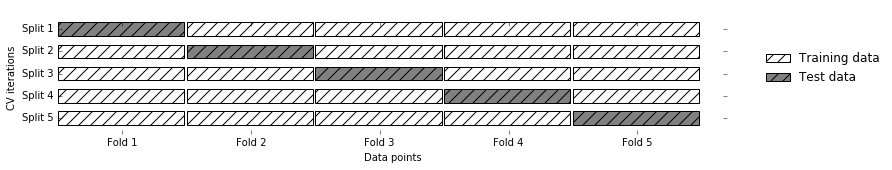<br>
Usually, the first fifth of the data is the first fold, the second fifth of the data is the
second fold, and so on.

### Cross validation in scikit-learn
Cross-validation is implemented in scikit-learn using the `cross_val_score` function
from the model_selection module. The parameters of the `cross_val_score`
function are the model we want to evaluate, the training data, and the ground-truth
labels. Let’s evaluate LogisticRegression on the iris dataset:

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
iris = load_iris()
logreg = LogisticRegression(max_iter=1000)
scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.98 0.96 0.98]


Here, `cross_val_score` performed three-fold cross-validation and therefore returned
three scores, which is the default. We can change the number of folds used
by changing the cv parameter:

In [5]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


It’s recommended to use at least five-fold cross-validation. A common way to summarize
the cross-validation accuracy is to compute the mean:

In [7]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.97


Using the mean cross-validation we can conclude that we expect the model to be
around 97% accurate on average. Looking at all five scores produced by the five-fold
cross-validation, we can also conclude that there is a relatively high variance in the
accuracy between folds, ranging from 100% accuracy to 93% accuracy. This could imply that the model is very dependent on the particular folds used for training, but it
could also just be a consequence of the small size of the dataset. There is a second
function you can use for cross-validation, called `cross_validate`. It has a similar
interface to cross_val_score, but returns a dictionary containing training and test
times (and optionally the training score, in addition to the test scores) for each split:

In [9]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg, iris.data, iris.target, cv=5, return_train_score=True)
display(res)

{'fit_time': array([0.01094174, 0.00641894, 0.00410414, 0.00408483, 0.00402522]),
 'score_time': array([0.00036001, 0.00021887, 0.00019407, 0.00018811, 0.00017166]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ]),
 'train_score': array([0.96666667, 0.96666667, 0.98333333, 0.98333333, 0.975     ])}

Using pandas, we can nicely display these results and compute summaries:

In [15]:
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.010942,0.000360,0.966667,0.966667
1,0.006419,0.000219,1.000000,0.966667
2,0.004104,0.000194,0.933333,0.983333
3,0.004085,0.000188,0.966667,0.983333
4,0.004025,0.000172,1.000000,0.975000


Mean times and scores:
 fit_time       0.005915
score_time     0.000227
test_score     0.973333
train_score    0.975000
dtype: float64


### Benefits of Cross-Validation
There are several benefits to using cross-validation instead of a single split into a
training and a test set. First, remember that `train_test_split` performs a random
split of the data. Imagine that we are “lucky” when randomly splitting the data, and all examples that are hard to classify end up in the training set. In that case, the test
set will only contain “easy” examples, and our test set accuracy will be unrealistically
high. Conversely, if we are “unlucky,” we might have randomly put all the hard-to-classify
examples in the test set and consequently obtain an unrealistically low score.
However, when using cross-validation, each example will be in the test set exactly
once: each example is in one of the folds, and each fold is the test set once. Therefore,
the model needs to generalize well to all of the samples in the dataset for all of the
cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensitive
our model is to the selection of the training dataset. For the iris dataset, we saw
accuracies between 90% and 100%. This is quite a range, and it provides us with an
idea about how the model might perform in the worst case and best case scenarios
when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is
that we use our data more effectively. When using `train_test_split`, we usually use
75% of the data for training and 25% of the data for evaluation. When using five-fold
cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the
model. When using 10-fold cross-validation, we can use nine-tenths of the data
(90%) to fit the model. More data will usually result in more accurate models.

The main disadvantage of cross-validation is increased computational cost. As we are
now training k models instead of a single model, cross-validation will be roughly k
times slower than doing a single split of the data.

It is important to keep in mind that cross-validation is not a way to
build a model that can be applied to new data. Cross-validation
does not return a model. When calling cross_val_score, multiple
models are built internally, but the purpose of `cross-validation` is
only to evaluate how well a given algorithm will generalize when
trained on a specific dataset.

### Stratified k-Fold Cross-Validation and Other Strategies

Splitting the dataset into k folds by starting with the first one-k-th part of the data, as
described in the previous section, might not always be a good idea. For example, let’s
have a look at the iris dataset:

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


As you can see, the first third of the data is the class 0, the second third is the class 1,
and the last third is the class 2. Imagine doing three-fold cross-validation on this
dataset. The first fold would be only class 0, so in the first split of the data, the test set
would be only class 0, and the training set would be only classes 1 and 2. As the
classes in training and test sets would be different for all three splits, the three-fold
cross-validation accuracy would be zero on this dataset. That is not very helpful, as
we can do much better than 0% accuracy on iris.

As the simple k-fold strategy fails here, scikit-learn does not use it for classification,
but rather uses **stratified k-fold cross-validation**. In stratified cross-validation, we
split the data such that the proportions between classes are the same in each fold as
they are in the whole dataset, as illustrated below:

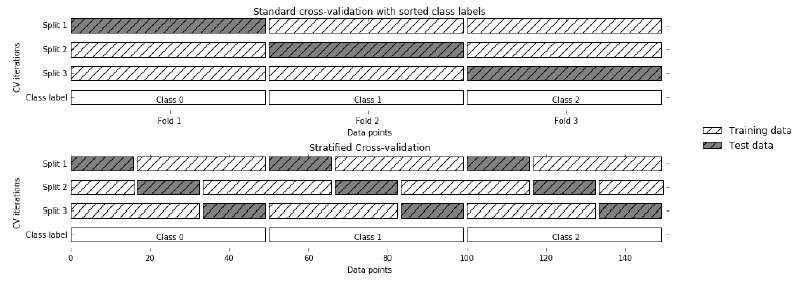


For example, if 90% of your samples belong to class A and 10% of your samples
belong to class B, then stratified cross-validation ensures that in each fold, 90% of
samples belong to class A and 10% of samples belong to class B.

It is usually a good idea to use stratified k-fold cross-validation instead of k-fold
cross-validation to evaluate a classifier, because it results in more reliable estimates of
generalization performance. In the case of only 10% of samples belonging to class B,
using standard k-fold cross-validation it might easily happen that one fold only contains
samples of class A. Using this fold as a test set would not be very informative
about the overall performance of the classifier.

For regression, scikit-learn uses the standard k-fold cross-validation by default. It
would be possible to also try to make each fold representative of the different values
the regression target has, but this is not a commonly used strategy.

#### More control over cross-validation
We saw earlier that we can adjust the number of folds that are used in
`cross_val_score` using the cv parameter. However, scikit-learn allows for much
finer control over what happens during the splitting of the data by providing a cross-validation
splitter as the cv parameter. For most use cases, the defaults of k-fold cross-validation
for regression and stratified k-fold for classification work well, but there
are some cases where you might want to use a different strategy. Say, for example, we
want to use the standard k-fold cross-validation on a classification dataset to reproduce
someone else’s results. To do this, we first have to import the KFold splitter class
from the model_selection module and instantiate it with the number of folds we
want to use:

In [19]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

Then, we can pass the kfold splitter object as the cv parameter to cross_val_score:

In [21]:
print("Cross-validation scores:\n{}".format(
cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


This way, we can verify that it is indeed a really bad idea to use three-fold (nonstratified)
cross-validation on the iris dataset:

In [23]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


Remember: each fold corresponds to one of the classes in the iris dataset, and so
nothing can be learned. Another way to resolve this problem is to shuffle the data
instead of stratifying the folds, to remove the ordering of the samples by label. We can
do that by setting the shuffle parameter of KFold to True. If we shuffle the data, we
also need to fix the random_state to get a reproducible shuffling. Otherwise, each run
of cross_val_score would yield a different result, as each time a different split would
be used (this might not be a problem, but can be surprising). Shuffling the data before
splitting it yields a much better result:

In [25]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.98 0.96 0.96]


#### Leave-one-out cross-validation
Another frequently used cross-validation method is **leave-one-out**. You can think of
leave-one-out cross-validation as k-fold cross-validation where each fold is a single
sample. For each split, you pick a single data point to be the test set. This can be very
time consuming, particularly for large datasets, but sometimes provides better estimates
on small datasets:

In [27]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.97


#### Shuffle-split cross-validation
Another, very flexible strategy for cross-validation is shuffle-split cross-validation. In
shuffle-split cross-validation, each split samples `train_size` many points for the
training set and `test_size` many (disjoint) point for the test set. This splitting is
repeated `n_splits` times. The figure below illustrates running four iterations of splitting a
dataset consisting of 10 points, with a training set of 5 points and test sets of 2 points
each (you can use integers for train_size and test_size to use absolute sizes for
these sets, or floating-point numbers to use fractions of the whole dataset):

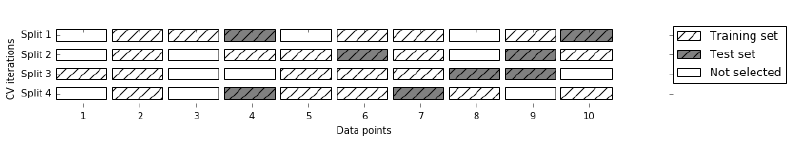

The following code splits the dataset into 50% training set and 50% test set for 10
iterations:

In [29]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.94666667 1.         0.97333333 0.94666667 0.97333333 0.98666667
 0.94666667 0.96       0.96       0.96      ]


Shuffle-split cross-validation allows for control over the number of iterations independently
of the training and test sizes, which can sometimes be helpful. It also allows
for using only part of the data in each iteration, by providing `train_size` and
`test_size` settings that don’t add up to one. Subsampling the data in this way can be
useful for experimenting with large datasets.

There is also a stratified variant of ShuffleSplit, aptly named StratifiedShuffleS
plit, which can provide more reliable results for classification tasks.

#### Cross-validation with groups
Another very common setting for cross-validation is when there are groups in the
data that are highly related. Say you want to build a system to recognize emotions
from pictures of faces, and you collect a dataset of pictures of 100 people where each
person is captured multiple times, showing various emotions. The goal is to build a
classifier that can correctly identify emotions of people not in the dataset. You could
use the default stratified cross-validation to measure the performance of a classifier
here. However, it is likely that pictures of the same person will be in both the training
and the test set. It will be much easier for a classifier to detect emotions in a face that
is part of the training set, compared to a completely new face. To accurately evaluate
the generalization to new faces, we must therefore ensure that the training and test
sets contain images of different people.

To achieve this, we can use GroupKFold, which takes an array of groups as argument
that we can use to indicate which person is in the image. The groups array here indicates
groups in the data that should not be split when creating the training and test
sets, and should not be confused with the class label.
This example of groups in the data is common in medical applications, where you
might have multiple samples from the same patient, but are interested in generalizing
to new patients. Similarly, in speech recognition, you might have multiple recordings
of the same speaker in your dataset, but are interested in recognizing speech of new
speakers.

The following is an example of using a synthetic dataset with a grouping given by the
`groups` array. The dataset consists of 12 data points, and for each of the data points,
groups specifies which group (think patient) the point belongs to. The groups specify
that there are four groups, and the first three samples belong to the first group, the
next four samples belong to the second group, and so on:

In [31]:
from sklearn.model_selection import GroupKFold
# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group,
# then the next four, etc.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75       0.6        0.66666667]


The samples don’t need to be ordered by group; we just did this for illustration purposes.
The splits that are calculated based on these labels are visualized below. As you can see, for each split, each group is either entirely in the training set or
entirely in the test set:

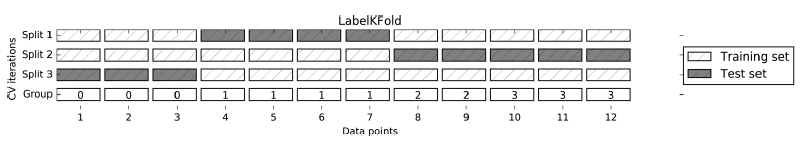


There are more splitting strategies for cross-validation in scikit-learn, which allow
for an even greater variety of use cases (you can find these in the scikit-learn user
guide). However, the standard KFold, StratifiedKFold, LeaveOneOut, and GroupKFold are by far
the most commonly used ones.

## Grid Search
Now that we know how to evaluate how well a model generalizes, we can take the
next step and improve the model’s generalization performance by tuning its parameters.
We discussed the parameter settings of many of the algorithms in scikit-learn
so far, and it is important to understand what the parameters mean
before trying to adjust them. Finding the values of the important parameters of a
model (the ones that provide the best generalization performance) is a tricky task, but
necessary for almost all models and datasets. Because it is such a common task, there
are standard methods in scikit-learn to help you with it. The most commonly used
method is grid search, which basically means trying all possible combinations of the
parameters of interest.

Consider the case of a kernel SVM with an RBF (radial basis function) kernel, as
implemented in the SVC class. As we discussed last week, there are two important
parameters: the kernel bandwidth, gamma, and the regularization parameter, C. Say we
want to try the values 0.001, 0.01, 0.1, 1, 10, and 100 for the parameter C, and the
same for gamma. Because we have six different settings for C and gamma that we want to
try, we have 36 combinations of parameters in total. Looking at all possible combinations
creates a table (or grid) of parameter settings for the SVM, as shown here:

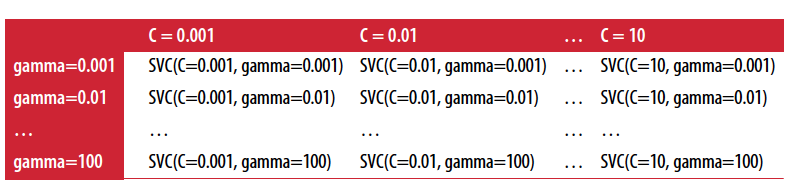


### Simple Grid Search
We can implement a simple grid search just as for loops over the two parameters,
training and evaluating a classifier for each combination:

In [35]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {} size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112 size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### The Danger of Overfitting the Parameters and the Validation Set
Given this result, we might be tempted to report that we found a model that performs
with 97% accuracy on our dataset. However, this claim could be overly optimistic (or just wrong), for the following reason: we tried many different parameters and
selected the one with best accuracy on the test set, but this accuracy won’t necessarily
carry over to new data. Because we used the test data to adjust the parameters, we can
no longer use it to assess how good the model is. This is the same reason we needed
to split the data into training and test sets in the first place; we need an independent
dataset to evaluate, one that was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the
training set to build the model, the validation (or development) set to select the
parameters of the model, and the test set to evaluate the performance of the selected
parameters, as below: 

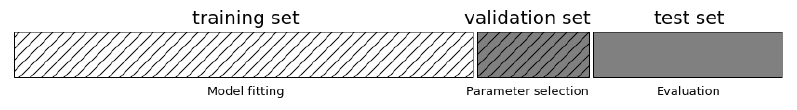



In [37]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {} size of validation set: {} size of test set: {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84 size of validation set: 28 size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably
because we used less data to train the model (X_train is smaller now because we split
our dataset twice). However, the score on the test set—the score that actually tells us
how well we generalize—is even lower, at 92%. So we can only claim to classify new
data 92% correctly, not 97% correctly as we thought before!

The distinction between the training set, validation set, and test set is fundamentally
important to applying machine learning methods in practice. Any choices made
based on the test set accuracy “leak” information from the test set into the model.
Therefore, it is important to keep a separate test set, which is only used for the final
evaluation. It is good practice to do all exploratory analysis and model selection using
the combination of a training and a validation set, and reserve the test set for a final
evaluation—this is even true for exploratory visualization. Strictly speaking, evaluating
more than one model on the test set and choosing the better of the two will result
in an overly optimistic estimate of how accurate the model is.

### Grid search with cross-validation
While the method of splitting the data into a training, a validation, and a test set that
we just saw is workable, and relatively commonly used, it is quite sensitive to how
exactly the data is split. From the output of the previous code snippet we can see that
grid search selects 'C': 10, 'gamma': 0.001 as the best parameters, while the output
of the code in the previous section selects 'C': 100, 'gamma': 0.001 as the best
parameters. For a better estimate of the generalization performance, instead of using
a single split into a training and a validation set, we can use cross-validation to evaluate
the performance of each parameter combination. This method can be coded up as
follows:

In [39]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        
        
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        
        # Let's print out to visualise
        print("gamma = {:.3f}, C = {:.3f}, {}, {:.3f}".format(gamma,C, scores, score) )
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set
print(best_parameters)
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

gamma = 0.001, C = 0.001, [0.34782609 0.34782609 0.36363636 0.36363636 0.40909091], 0.366
gamma = 0.001, C = 0.010, [0.34782609 0.34782609 0.36363636 0.36363636 0.40909091], 0.366
gamma = 0.001, C = 0.100, [0.34782609 0.34782609 0.36363636 0.36363636 0.40909091], 0.366
gamma = 0.001, C = 1.000, [0.69565217 0.69565217 0.68181818 0.68181818 0.72727273], 0.696
gamma = 0.001, C = 10.000, [0.91304348 0.91304348 1.         0.90909091 0.95454545], 0.938
gamma = 0.001, C = 100.000, [1.         0.95652174 1.         0.90909091 0.95454545], 0.964
gamma = 0.010, C = 0.001, [0.34782609 0.34782609 0.36363636 0.36363636 0.40909091], 0.366
gamma = 0.010, C = 0.010, [0.34782609 0.34782609 0.36363636 0.36363636 0.40909091], 0.366
gamma = 0.010, C = 0.100, [0.69565217 0.69565217 0.68181818 0.68181818 0.72727273], 0.696
gamma = 0.010, C = 1.000, [0.91304348 0.91304348 1.         0.90909091 0.95454545], 0.938
gamma = 0.010, C = 10.000, [1.         0.95652174 1.         0.90909091 0.95454545], 0.964
gamma 

SVC(C=10, gamma=0.1)

To evaluate the accuracy of the SVM using a particular setting of C and gamma using
five-fold cross-validation, we need to train 36 * 5 = 180 models. As you can imagine,
the main downside of the use of cross-validation is the time it takes to train all these
models.

As we said earlier, cross-validation is a way to evaluate a given algorithm
on a specific dataset. However, it is often used in conjunction
with parameter search methods like grid search. For this reason,
many people use the term cross-validation colloquially to refer to
grid search with cross-validation.

The overall process of splitting the data, running the grid search, and evaluating the
final parameters is illustrated below

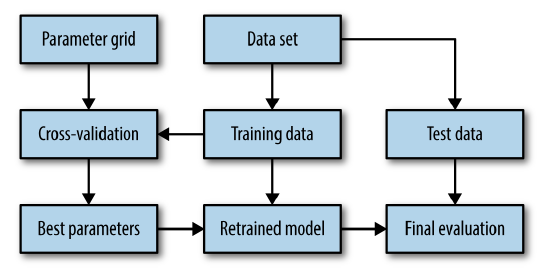

Because grid search with cross-validation is such a commonly used method to adjust
parameters, scikit-learn provides the `GridSearchCV` class, which implements it in
the form of an estimator. To use the `GridSearchCV` class, you first need to specify the
parameters you want to search over using a dictionary. GridSearchCV will then perform
all the necessary model fits. The keys of the dictionary are the names of parameters
we want to adjust (as given when constructing the model—in this case, C and
gamma), and the values are the parameter settings we want to try out. Trying the values
0.001, 0.01, 0.1, 1, 10, and 100 for C and gamma translates to the following
dictionary:

In [41]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


We can now instantiate the GridSearchCV class with the model (SVC), the parameter
grid to search (param_grid), and the cross-validation strategy we want to use (say,
five-fold stratified cross-validation):

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

GridSearchCV will use cross-validation in place of the split into a training and validation
set that we used before. However, we still need to split the data into a training
and a test set, to avoid overfitting the parameters:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

The grid_search object that we created behaves just like a classifier; we can call the
standard methods fit, predict, and score on it. However, when we call fit, it will
run cross-validation for each combination of parameters we specified in param_grid:

In [47]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

Fitting the GridSearchCV object not only searches for the best parameters, but also
automatically fits a new model on the whole training dataset with the parameters that
yielded the best cross-validation performance. What happens in `fit` is therefore
equivalent to the result of the code we saw at the beginning of this section. The
`GridSearchCV` class provides a very convenient interface to access the retrained
model using the predict and score methods. To evaluate how well the best found
parameters generalize, we can call score on the test set:

In [49]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


Choosing the parameters using cross-validation, we actually found a model that achieves
97% accuracy on the test set. The important thing here is that we did not use the
test set to choose the parameters. The parameters that were found are stored in the `best_params_` attribute, and the best cross-validation accuracy (the mean accuracy
over the different splits for this parameter setting) is stored in `best_score_`:

In [51]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


Again, be careful not to confuse best_score_ with the generalization
performance of the model as computed by the score method
on the test set. Using the score method (or evaluating the output of
the predict method) employs a model trained on the whole training
set. The best_score_ attribute stores the mean cross-validation
accuracy, with cross-validation performed on the training set.

Sometimes it is helpful to have access to the actual model that was found—for example,
to look at coefficients or feature importances. You can access the model with the
best parameters trained on the whole training set using the best_estimator_
attribute:

In [53]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, gamma=0.1)


### Analyzing the result of cross-validation
It is often helpful to visualize the results of cross-validation, to understand how the
model generalization depends on the parameters we are searching. As grid searches
are quite computationally expensive to run, often it is a good idea to start with a relatively
coarse and small grid. We can then inspect the results of the cross-validated
grid search, and possibly expand our search. The results of a grid search can be found
in the cv_results_ attribute, which is a dictionary storing all aspects of the search. It contains a lot of details, as you can see in the following output, and is best looked at
after converting it to a pandas DataFrame:

In [55]:
import pandas as pd
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002023,0.001330,0.000803,0.000610,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
1,0.000569,0.000190,0.000284,0.000042,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
2,0.000450,0.000161,0.000248,0.000058,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
3,0.000538,0.000404,0.000215,0.000015,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
4,0.000319,0.000004,0.000198,0.000002,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581


Each row in results corresponds to one particular parameter setting. For each setting,
the results of all cross-validation splits are recorded, as well as the mean and
standard deviation over all splits. As we were searching a two-dimensional grid of
parameters (C and gamma), this is best visualized as a heat map. First we
extract the mean validation scores, then we reshape the scores so that the axes correspond
to C and gamma:

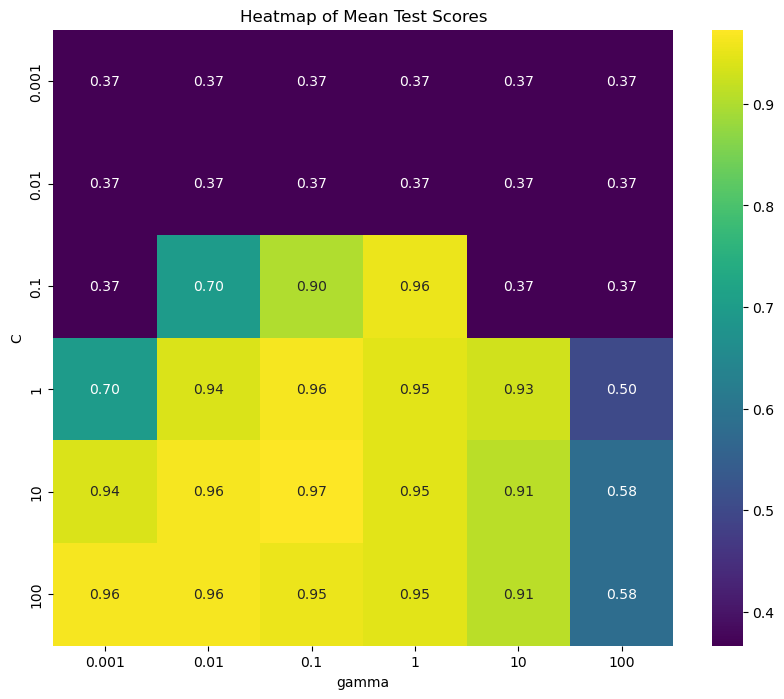

In [57]:
scores = np.array(results.mean_test_score).reshape(6, 6)

plt.figure(figsize=(10, 8))
sns.heatmap(scores, annot=True, fmt=".2f", xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis")
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Heatmap of Mean Test Scores')
plt.show()



Each point in the heat map corresponds to one run of cross-validation, with a particular
parameter setting. The color encodes the cross-validation accuracy, with light
colors meaning high accuracy and dark colors meaning low accuracy. You can see
that SVC is very sensitive to the setting of the parameters. For many of the parameter
settings, the accuracy is around 40%, which is quite bad; for other settings the accuracy
is around 96%. We can take away from this plot several things. First, the parameters
we adjusted are very important for obtaining good performance. Both parameters
(C and gamma) matter a lot, as adjusting them can change the accuracy from 40% to
96%. Additionally, the ranges we picked for the parameters are ranges in which we
see significant changes in the outcome. It’s also important to note that the ranges for
the parameters are large enough: the optimum values for each parameter are not on
the edges of the plot.

Now let’s look at some plots where the result is less ideal,
because the search ranges were not chosen properly:

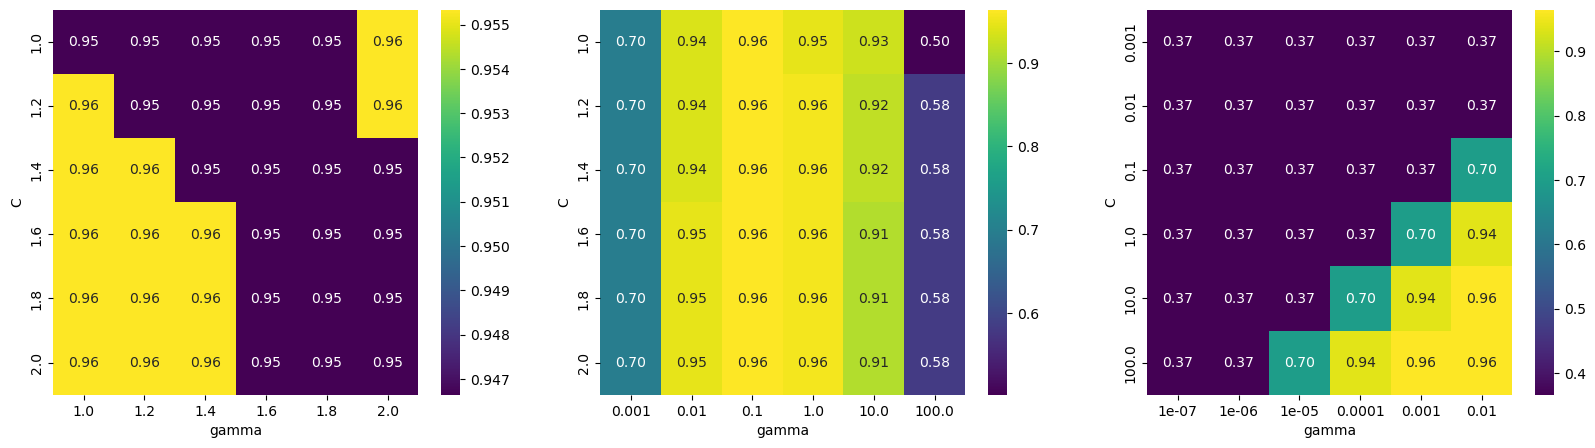

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6), 'gamma': np.linspace(1, 2, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6),'gamma': np.logspace(-3, 2, 6)}
param_grid_range = {'C': np.logspace(-3, 2, 6),'gamma': np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    sns.heatmap(scores, annot=True, fmt=".2f", xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis", ax=ax)
    ax.set_xlabel('gamma')
    ax.set_ylabel('C')


The first panel shows no changes at all, with a constant color over the whole parameter
grid. In this case, this is caused by improper scaling and range of the parameters C
and gamma. However, if no change in accuracy is visible over the different parameter
settings, it could also be that a parameter is just not important at all. It is usually good
to try very extreme values first, to see if there are any changes in the accuracy as a
result of changing a parameter.

The second panel shows a vertical stripe pattern. This indicates that only the setting
of the gamma parameter makes any difference. This could mean that the gamma parameter
is searching over interesting values but the C parameter is not—or it could mean
the C parameter is not important.

The third panel shows changes in both C and gamma. However, we can see that in the
entire bottom left of the plot, nothing interesting is happening. We can probably
exclude the very small values from future grid searches. The optimum parameter setting
is at the top right. As the optimum is in the border of the plot, we can expect that
there might be even better values beyond this border, and we might want to change
our search range to include more parameters in this region.

Tuning the parameter grid based on the cross-validation scores is perfectly fine, and a
good way to explore the importance of different parameters. However, you should
not test different parameter ranges on the final test set—as we discussed earlier, evaluation of the test set should happen only once we know exactly what model we want
to use.

### Search over spaces that are not grids

In some cases, trying all possible combinations of all parameters as GridSearchCV
usually does, is not a good idea. For example, SVC has a kernel parameter, and
depending on which kernel is chosen, other parameters will be relevant. If kernel='linear', the model is linear, and only the C parameter is used. If kernel='rbf',
both the C and gamma parameters are used (but not other parameters like degree). In
this case, searching over all possible combinations of C, gamma, and kernel wouldn’t
make sense: if kernel='linear', gamma is not used, and trying different values for
gamma would be a waste of time. To deal with these kinds of “conditional” parameters,
GridSearchCV allows the param_grid to be a list of dictionaries. Each dictionary in the
list is expanded into an independent grid. A possible grid search involving kernel and
parameters could look like this:

In [61]:
param_grid = [ {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
               {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In the first grid, the kernel parameter is always set to 'rbf' (note that the entry for
kernel is a list of length one), and both the C and gamma parameters are varied. In the
second grid, the kernel parameter is always set to linear, and only C is varied. Now
let’s apply this more complex parameter search:

In [63]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


Let’s look at the cv_results_ again. As expected, if kernel is 'linear', then only C is
varied:

In [65]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.000732,0.000439,0.000657,0.000361,0.000341,0.000338,0.000481,0.000394,0.000355,0.000369,...,0.000278,0.000288,0.0004,0.000462,0.00034,0.000286,0.000266,0.000263,0.000241,0.000257
std_fit_time,0.000435,0.000135,0.000317,0.000041,0.000014,0.000011,0.000245,0.000022,0.000025,0.00004,...,0.000088,0.00003,0.00005,0.000028,0.000017,0.000007,0.000013,0.000036,0.000008,0.000026
mean_score_time,0.000335,0.000248,0.000254,0.000213,0.000212,0.000206,0.000231,0.00024,0.000223,0.00022,...,0.000173,0.000167,0.000219,0.00024,0.000171,0.000154,0.000152,0.000152,0.00014,0.000153
std_score_time,0.000154,0.000029,0.000035,0.000007,0.000005,0.000005,0.000026,0.000026,0.00001,0.000014,...,0.000051,0.000014,0.000062,0.000019,0.000018,0.000001,0.000005,0.000013,0.000002,0.000011
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


### Using different cross-validation strategies with grid search

Similarly to cross_val_score, GridSearchCV uses stratified k-fold cross-validation
by default for classification, and k-fold cross-validation for regression. However, you
can also pass any cross-validation splitter, as described in “More control over crossvalidation”, as the cv parameter in GridSearchCV. In particular, to get
only a single split into a training and a validation set, you can use ShuffleSplit or
StratifiedShuffleSplit with n_splits=1. This might be helpful for very large
datasets, or very slow models.

### Nested cross-validation

In the preceding examples, we went from using a single split of the data into training,
validation, and test sets to splitting the data into training and test sets and then performing
cross-validation on the training set. But when using GridSearchCV as described earlier, we still have a single split of the data into training and test sets,
which might make our results unstable and make us depend too much on this single
split of the data. We can go a step further, and instead of splitting the original data
into training and test sets once, use multiple splits of cross-validation. This will result
in what is called nested cross-validation. In nested cross-validation, there is an outer
loop over splits of the data into training and test sets. For each of them, a grid search
is run (which might result in different best parameters for each split in the outer
loop). Then, for each outer split, the test set score using the best settings is reported.

The result of this procedure is a list of scores—not a model, and not a parameter setting.
The scores tell us how well a model generalizes, given the best parameters found
by grid search. As it doesn’t provide a model that can be used on new data, nested
cross-validation is rarely used when looking for a predictive model to apply to future
data. However, it can be useful for evaluating how well a given model works on a particular
dataset.

Implementing nested cross-validation in scikit-learn is straightforward. We call
cross_val_score with an instance of GridSearchCV as the model:

In [68]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score( GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


The result of our nested cross-validation can be summarized as “SVC can achieve 98%
mean cross-validation accuracy on the iris dataset”—nothing more and nothing
less.

Here, we used stratified five-fold cross-validation in both the inner and the outer
loop. As our param_grid contains 36 combinations of parameters, this results in a
whopping 36 * 5 * 5 = 900 models being built, making nested cross-validation a very
expensive procedure. Here, we used the same cross-validation splitter in the inner
and the outer loop; however, this is not necessary and you can use any combination
of cross-validation strategies in the inner and outer loops. It can be a bit tricky to
understand what is happening in the single line given above, and it can be helpful to
visualize it as for loops, as done in the following simplified implementation:

In [72]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test parts)

    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf
        #-np.inf stands for negative infinity
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters

        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

Now, let’s run this function on the iris dataset:

In [74]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


### Parallelizing cross-validation and grid search

While running a grid search over many parameters and on large datasets can be computationally
challenging, it is also embarrassingly parallel. This means that building a model using a particular parameter setting on a particular cross-validation split can
be done completely independently from the other parameter settings and models.
This makes grid search and cross-validation ideal candidates for parallelization over
multiple CPU cores or over a cluster. You can make use of multiple cores in Grid
SearchCV and cross_val_score by setting the n_jobs parameter to the number of
CPU cores you want to use. You can set n_jobs=-1 to use all available cores.
Setting n_jobs in both the model and GridSearchCV is supported. If your dataset and model are very large, it might be
that using many cores uses up too much memory, and you should monitor your
memory usage when building large models in parallel. We will cover these topics in Week 8.

## Evaluation metrics and Scoring

So far, we have evaluated classification performance using accuracy (the fraction of
correctly classified samples) and regression performance using R2. However, these are
only two of the many possible ways to summarize how well a supervised model performs
on a given dataset. In practice, these evaluation metrics might not be appropriate
for your application, and it is important to choose the right metric when selecting
between models and adjusting parameters.

When selecting a metric, you should always have the end goal of the machine learning
application in mind. In practice, we are usually interested not just in making
accurate predictions, but in using these predictions as part of a larger decision making
process. When choosing a model or adjusting parameters, you should pick the model or parameter values that
have the most positive influence on the goal. Often this is hard, as assessing the impact of a particular model might require appyling it
in a real-life system.

In this section, we will first discuss metrics for the important special case of binary
classification, then turn to multiclass classification and finally regression.

## Metrics for Binary Classification

Binary classification is arguably the most common and conceptually simple application
of machine learning in practice. However, there are still a number of caveats in
evaluating even this simple task. Before we dive into alternative metrics, let’s have a
look at the ways in which measuring accuracy might be misleading. Remember that
for binary classification, we often speak of a positive class and a negative class, with
the understanding that the positive class is the one we are looking for.

### Kinds of errors

Often, accuracy is not a good measure of predictive performance, as the number of
mistakes we make does not contain all the information we are interested in. Imagine
an application to screen for the early detection of cancer using an automated test. If
the test is negative, the patient will be assumed healthy, while if the test is positive, the
patient will undergo additional screening. Here, we would call a positive test (an indication
of cancer) the positive class, and a negative test the negative class. We can’t
assume that our model will always work perfectly, and it will make mistakes. For any
application, we need to ask ourselves what the consequences of these mistakes might
be in the real world.

One possible mistake is that a healthy patient will be classified as positive, leading to
additional testing. This leads to some costs and an inconvenience for the patient (and
possibly some mental distress). An incorrect positive prediction is called a **false positive**. The other possible mistake is that a sick patient will be classified as negative, and
will not receive further tests and treatment. The undiagnosed cancer might lead to
serious health issues, and could even be fatal. A mistake of this kind—an incorrect
negative prediction—is called a **false negative**. In statistics, a false positive is also
known as **type I error**, and a false negative as **type II error**. We will stick to “false negative”
and “false positive,” as they are more explicit and easier to remember. In the cancer
diagnosis example, it is clear that we want to avoid false negatives as much as
possible, while false positives can be viewed as more of a minor nuisance.

While this is a particularly drastic example, the consequence of false positives and
false negatives are rarely the same. 

### Imbalanced data sets
Types of errors play an important role when one of two classes is much more frequent
than the other one. This is very common in practice and make your estimates of accuracy misleading. For example,  let’s say you build a classifier that is 99% accurate on a task.
What does that tell you? 99% accuracy sounds impressive, but this doesn’t take the
class imbalance into account. Perhaps you can achieve 99% accuracy without building a
machine learning model, by always predicting one of the classes. 

To illustrate, we’ll create a 9:1 imbalanced dataset from the digits dataset, by classifying
the digit 9 against the nine other classes. We will make use of the `DummyClassifier`, which just predicts the majority class:

In [76]:
from sklearn.datasets import load_digits
digits = load_digits()
#digits.target == 9 returns a boolean array where each element is True if the corresponding label is 9 and False otherwise
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))


Unique predicted labels: [False]
Test score: 0.90


We obtained close to 90% accuracy without learning anything! This might seem striking,
but think about it for a minute. Imagine someone telling you their model is 90%
accurate. You might think they did a very good job. But depending on the problem,
that might be possible by just predicting one class! Let’s compare this against using an
actual classifier:

In [78]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


According to accuracy, the DecisionTreeClassifier is only slightly better than the
constant predictor. This could indicate either that something is wrong with how we
used DecisionTreeClassifier, or that accuracy is in fact not a good measure here.
For comparison purposes, let’s evaluate two more classifiers, LogisticRegression
and the default DummyClassifier, which makes random predictions but produces
classes with the same proportions as in the training set:

In [80]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1,max_iter=1000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.81
logreg score: 0.98


The dummy classifier that produces random output is clearly the worst of the lot
(according to accuracy), while LogisticRegression produces very good results.
However, even the random classifier yields over 80% accuracy. This makes it very
hard to judge which of these results is actually helpful. The problem here is that accuracy
is an inadequate measure for quantifying predictive performance in this imbalanced
setting. For the rest of this chapter, we will explore alternative metrics that
provide better guidance in selecting models. In particular, we would like to have metrics
that tell us how much better a model is than making “most frequent” predictions
or random predictions, as they are computed in pred_most_frequent and
pred_dummy. If we use a metric to assess our models, it should definitely be able to
weed out these nonsense predictions.

### Confusion matrices
One of the most comprehensive ways to represent the result of evaluating binary classification
is using confusion matrices. Let’s inspect the predictions of `LogisticRegressio`n from the previous section using the confusion_matrix function. We already
stored the predictions on the test set in pred_logreg:

In [82]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[402   1]
 [  6  41]]


The output of confusion_matrix is a two-by-two array, where the rows correspond
to the true classes and the columns correspond to the predicted classes. Each entry counts how often a sample that belongs to the class corresponding to the row (here,
“not nine” and “nine”) was classified as the class corresponding to the column. The
following plot illustrates this meaning: <br>
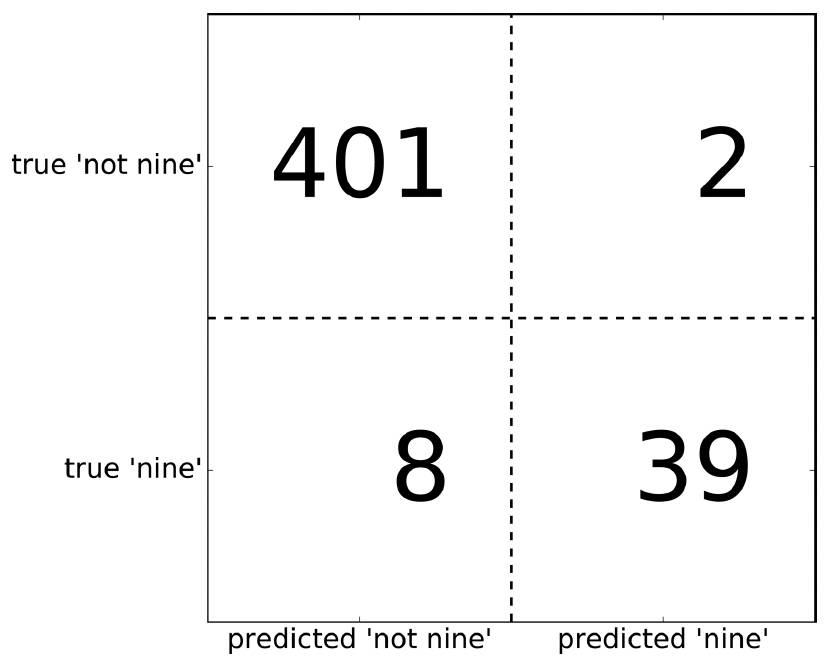

Entries on the main diagonal3 of the confusion matrix correspond to correct classifications,
while other entries tell us how many samples of one class got mistakenly classified
as another class.
If we declare “a nine” the positive class, we can relate the entries of the confusion
matrix with the terms false positive and false negative that we introduced earlier. To
complete the picture, we call correctly classified samples belonging to the positive
class true positives and correctly classified samples belonging to the negative class true
negatives. These terms are usually abbreviated FP, FN, TP, and TN and lead to the following
interpretation for the confusion matrix:<br>
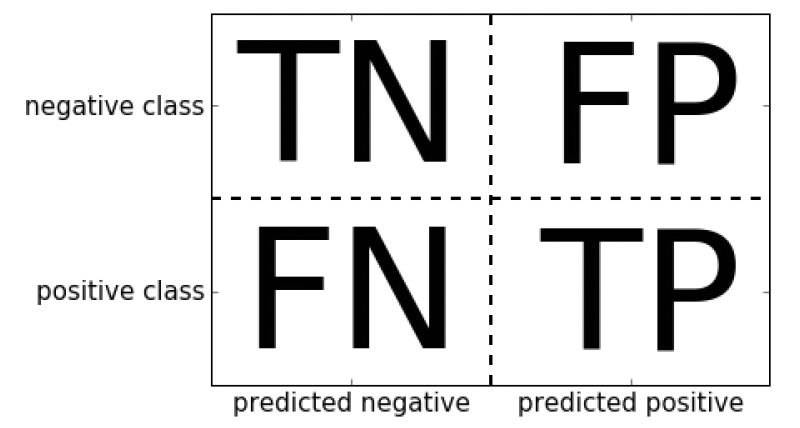

Now let’s use the confusion matrix to compare the models we fitted earlier (the two
dummy models, the decision tree, and the logistic regression):

In [84]:
print("Most frequent class:")
print("Accuracy: {:.2f}".format(dummy_majority.score(X_test, y_test)))
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print("Accuracy: {:.2f}".format(dummy.score(X_test, y_test)))
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print("Accuracy: {:.2f}".format(tree.score(X_test, y_test)))
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print("Accuracy: {:.2f}".format(logreg.score(X_test, y_test)))
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
Accuracy: 0.90
[[403   0]
 [ 47   0]]

Dummy model:
Accuracy: 0.82
[[370  33]
 [ 41   6]]

Decision tree:
Accuracy: 0.92
[[390  13]
 [ 24  23]]

Logistic Regression
Accuracy: 0.98
[[402   1]
 [  6  41]]


Looking at the confusion matrix, it is quite clear that something is wrong with
pred_most_frequent, because it always predicts the same class (here the negative class). pred_dummy, on the
other hand, has a very small number of true positives, particularly compared to
the number of false negatives and false positives—there are many more false positives than true positives! The predictions made by the decision tree make much more
sense than the dummy predictions, even though the accuracy was nearly the same.
Finally, we can see that logistic regression does better than pred_tree in all aspects: it
has more true positives and true negatives while having fewer false positives and false
negatives. From this comparison, it is clear that only the decision tree and the logistic
regression give reasonable results, and that the logistic regression works better than
the tree on all accounts. However, inspecting the full confusion matrix is a bit cumbersome,
and while we gained a lot of insight from looking at all aspects of the
matrix, the process was very manual and qualitative. There are several ways to summarize
the information in the confusion matrix, which we will discuss next.

### Relation to accuracy
We already saw one way to summarize the result in the confusion
matrix—by computing accuracy, which can be expressed as:

$$ Accuracy = \frac{ TP + TN }{ TP + TN + FP + FN } $$

In other words, accuracy is the number of correct predictions (TP and TN) divided
by the number of all samples (all entries of the confusion matrix summed up).

### Precision, recall, and f-score. 
There are several other ways to summarize the confusion
matrix, with the most common ones being precision and recall. **Precision measures
how many of the samples predicted as positive are actually positive**:

$$ Precision = \frac{TP}{TP+FP} $$ 

Precision is used as a performance metric when the goal is to limit the number of
false positives. As an example, imagine a model for predicting whether a new drug
will be effective in treating a disease in clinical trials. Clinical trials are notoriously
expensive, and a pharmaceutical company will only want to run an experiment if it is
very sure that the drug will actually work. Therefore, it is important that the model
does not produce many false positives—in other words, that it has a high precision.
Precision is also known as positive predictive value (PPV).

**Recall, on the other hand, measures how many of the positive samples are captured
by the positive predictions**:

$$ Recall = \frac{TP}{TP+FN} $$ 

Recall is used as performance metric when we need to identify all positive samples;
that is, when it is important to avoid false negatives. The cancer diagnosis example from earlier in this chapter is a good example for this: it is important to find all people
that are sick, possibly including healthy patients in the prediction. Other names
for recall are sensitivity, hit rate, or true positive rate (TPR).

There is a trade-off between optimizing recall and optimizing precision. You can trivially
obtain a perfect recall if you predict all samples to belong to the positive class—
there will be no false negatives, and no true negatives either. However, predicting all
samples as positive will result in many false positives, and therefore the precision will
be very low. On the other hand, if you find a model that predicts only the single data
point it is most sure about as positive and the rest as negative, then precision will be
perfect (assuming this data point is in fact positive), but recall will be very bad.

Precision and recall are only two of many classification measures
derived from TP, FP, TN, and FN.  In the machine learning community,
precision and recall are arguably the most commonly used
measures for binary classification, but other communities might
use other related metrics.

So, while precision and recall are very important measures, looking at only one of
them will not provide you with the full picture. One way to summarize them is the
f-score or f-measure, which is with the harmonic mean of precision and recall:

$$ F = 2 · \frac{precision \times recall}{ precision + recall } $$

This particular variant is also known as the **f1-score**. As it takes precision and recall
into account, it can be a better measure than accuracy on imbalanced binary classification
datasets. Let’s run it on the predictions for the “nine vs. rest” dataset that we
computed earlier. Here, we will assume that the “nine” class is the positive class (it is
labeled as True while the rest is labeled as False), so the positive class is the minority
class:


In [86]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.14
f1 score tree: 0.55
f1 score logistic regression: 0.92


We can note two things here. First, we might get an error message for the most_frequent
prediction, as there were no predictions of the positive class (which makes the
denominator in the f-score zero). We cana alos see a pretty strong distinction between
the dummy predictions and the tree predictions, which wasn’t clear when looking at
accuracy alone. Using the f-score for evaluation, we summarized the predictive performance
again in one number. However, the f-score seems to capture our intuition
of what makes a good model much better than accuracy did. A disadvantage of the
f-score, however, is that it is harder to interpret and explain than accuracy.

If we want a more comprehensive summary of precision, recall, and f1-score, we can
use the classification_report convenience function to compute all three at once,
and print them in a nice format:

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The classification_report function produces one line per class (here, True and
False) and reports precision, recall, and f-score with this class as the positive class.
Before, we assumed the minority “nine” class was the positive class. If we change the
positive class to “not nine,” we can see from the output of classification_report
that we obtain an f-score of 0.94 with the most_frequent model. Furthermore, for the
“not nine” class we have a recall of 1, as we classified all samples as “not nine.” The
last column next to the f-score provides the support of each class, which simply means
the number of samples in this class according to the ground truth.

Three additional rows in the classification report show averages of the precision,
recall, and f1-score. The macro average simply computes the average across the
classes, while the weighted average computes a weighted average, weighted by the number of samples in the class. Because they are averages over both classes, these
metrics don’t require a notion of positive class, and in contrast to just looking at precision
or just looking at recall for the positive class, averaging over both classes provides
a meaningful metric in a single number. Here are two more reports, one for the
dummy classifier and one for the logistic regression:

In [90]:
print(classification_report(y_test, pred_dummy,target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      0.92      0.91       403
        nine       0.15      0.13      0.14        47

    accuracy                           0.84       450
   macro avg       0.53      0.52      0.52       450
weighted avg       0.82      0.84      0.83       450



In [92]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



As you may notice when looking at the reports, picking which class is
declared the positive class has a big impact on the metrics dummy metric. While the f-score for the
dummy classification is 0.10 (vs. 0.89 for the logistic regression) on the “nine” class,
for the “not nine” class it is 0.91 vs. 0.99, which both seem like reasonable results.
Looking at all the numbers together paints a pretty accurate picture, though, and we
can clearly see the superiority of the logistic regression model.

### Taking uncertainty into account
The confusion matrix and the classification report provide a very detailed analysis of
a particular set of predictions. However, the predictions themselves already threw
away a lot of information that is contained in the model such as the probability of prediction. Making predictions can be seen as
thresholding the output of `decision_function` or `predict_proba` at a certain fixed
point—in binary classification we use 0 for the decision function and 0.5 for
`predict_proba`.

The following is an example of an imbalanced binary classification task, with 400
points in the negative class classified against 50 points in the positive class. We can use the classification_report function to evaluate precision and recall for
both classes:
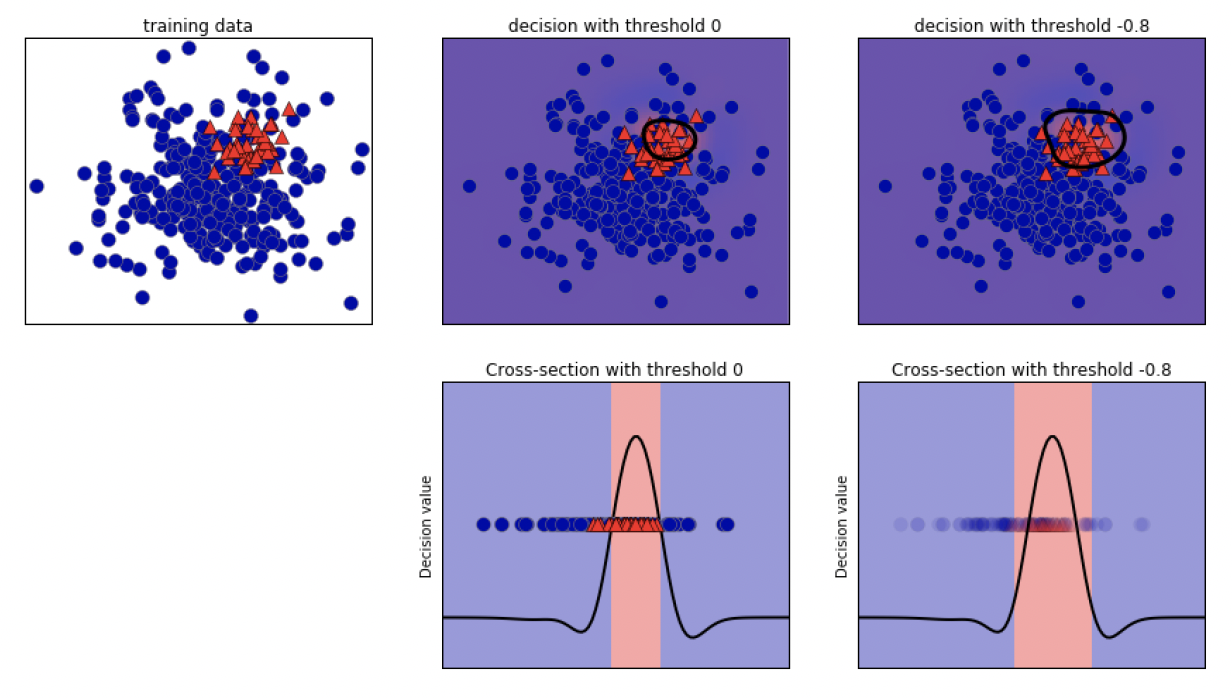

In [128]:
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05,probability=True).fit(X_train, y_train)
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



For class 1, we get a fairly small precision, and recall is mixed. Because class 0 is so
much larger, the classifier focuses on getting class 0 right, and not the smaller class 1.
Let’s assume in our application it is more important to have a high recall for class 1, as
in the cancer screening example earlier. This means we are willing to risk more false
positives (false class 1) in exchange for more true positives (which will increase the
recall). The predictions generated by svc.predict really do not fulfill this requirement,
but we can adjust the predictions to focus on a higher recall of class 1 by
changing the decision threshold away from 0. By default, points with a deci
sion_function value greater than 0 will be classified as class 1. We want more points
to be classified as class 1, so we need to decrease the threshold:

In [130]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



As expected, the recall of class 1 went up, and the precision went down. We are now
classifying a larger region of space as class 1. If you value precision over recall or the other way around, or you data is
heavily imbalanced, changing the decision threshold is the easiest way to obtain better results. As the decision_function can have arbitrary ranges, it is hard to provide
a rule of thumb regarding how to pick a threshold. If you do set a threshold, you need
to be careful not to do so using the test set. As with any other parameter, setting a
decision threshold on the test set is likely to yield overly optimistic results. Use a validation
set or cross-validation instead.

Note: For simplicity, we changed the threshold value based on test set
results in the code above. In practice, you need to use a hold-out
validation set, not the test set. As with any other parameter, setting
a decision threshold on the test set is likely to yield overly optimistic
results. Use a validation set or cross-validation instead.

Picking a threshold for models that implement the `predict_proba` method can be
easier, as the output of predict_proba is on a fixed 0 to 1 scale, and models probabilities.
By default, the threshold of 0.5 means that if the model is more than 50% “sure”
that a point is of the positive class, it will be classified as such. Increasing the threshold
means that the model needs to be more confident to make a positive decision
(and less confident to make a negative decision). While working with probabilities
may be more intuitive than working with arbitrary thresholds, not all models provide
realistic models of uncertainty (a DecisionTree that is grown to its full depth is
always 100% sure of its decisions, even though it might often be wrong). This relates
to the concept of calibration: a calibrated model is a model that provides an accurate
measure of its uncertainty. 

### Receiver operating characteristics (ROC) and AUC
As we just discussed, changing the threshold that is used to make a classification decision
in a model is a way to adjust the trade-off of precision and recall for a given classifier. Precision-recall curves are one way to do this and are covered in Muller and Guido (pg 295). There is another more commonly used tool used to analyze the behavior of classifiers at different thresholds: the receiver operating characteristics curve, or ROC curve for
short. Similar to the precision-recall curve, the ROC curve considers all possible
thresholds for a given classifier, but instead of reporting precision and recall, it shows
the false positive rate (FPR) against the true positive rate (TPR). Recall that the true
positive rate is simply another name for recall, while the false positive rate is the fraction
of false positives out of all negative samples:

$$ FPR = \frac{FP}{ FP + TN } $$

The ROC curve can be computed using the `roc_curve` function.


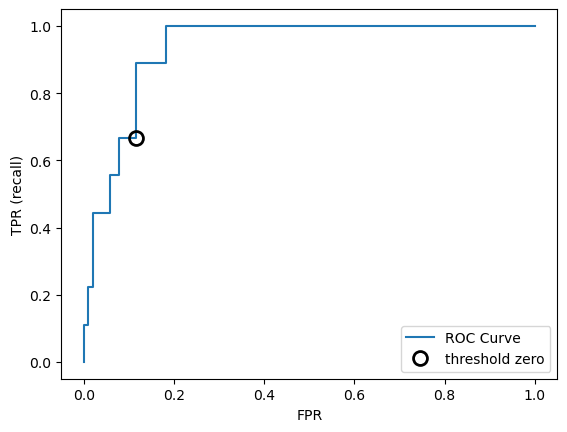

In [136]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

For the ROC curve, the ideal curve is close to the top left: you want a classifier that
produces a high recall while keeping a low false positive rate. Compared to the default
threshold of 0, the curve shows that we can achieve a significantly higher recall
(around 0.9) while only increasing the FPR slightly. The point closest to the top left
might be a better operating point than the one chosen by default. Again, be aware that
choosing a threshold should not be done on the test set, but on a separate validation
set.

We can also fit a random forest classifier to the blobs data and compare the ROC curves for RF and SVC:

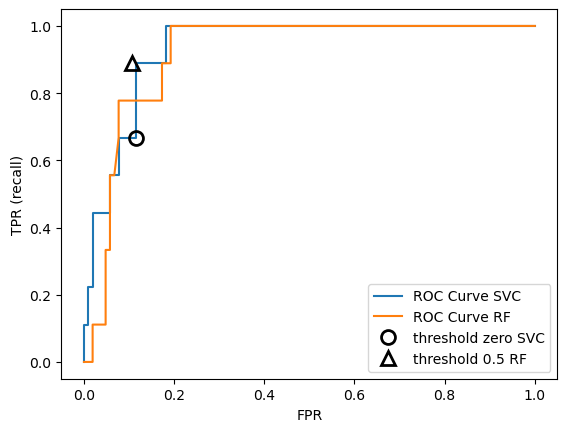

In [100]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])  # Note that random forest only provides a predict_proba method
plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

We often want to summarize the ROC curve using a
single number, the area under the curve (this is commonly just referred to as the
AUC, and it is understood that the curve in question is the ROC curve). We can compute
the area under the ROC curve using the roc_auc_score function:

In [102]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.917
AUC for SVC: 0.934


Comparing the random forest and SVM using the AUC score, we find that the random
forest performs quite a bit better than the SVM. Recall that because AUC is the
area under a curve that goes from 0 to 1, AUC always returns a value between 0
(worst) and 1 (best). Predicting randomly always produces an AUC of 0.5, no matter
how imbalanced the classes in a dataset are. This makes AUC a much better metric
for imbalanced classification problems than accuracy. The AUC can be interpreted as
evaluating the ranking of positive samples. It’s equivalent to the probability that a randomly
picked point of the positive class will have a higher score according to the classifier
than a randomly picked point from the negative class. So, a perfect AUC of 1 means that all positive points have a higher score than all negative points. For classification
problems with imbalanced classes, using AUC for model selection is often
much more meaningful than using accuracy.

## Metrics for Multiclass Classification

Now that we have discussed evaluation of binary classification tasks in depth, let’s
move on to metrics to evaluate multiclass classification. Basically, all metrics for
multiclass classification are derived from binary classification metrics, but averaged
over all classes. Accuracy for multiclass classification is again defined as the fraction
of correctly classified examples. And again, when classes are imbalanced, accuracy is
not a great evaluation measure. Imagine a three-class classification problem with 85%
of points belonging to class A, 10% belonging to class B, and 5% belonging to class C.
What does being 85% accurate mean on this dataset? In general, multiclass classification
results are harder to understand than binary classification results. Apart from
accuracy, common tools are the confusion matrix and the classification report we saw
in the binary case in the previous section. Let’s apply these two detailed evaluation
methods on the task of classifying the 10 different handwritten digits in the digits
dataset:

In [104]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

lr = LogisticRegression(max_iter=5000).fit(X_train, y_train)
pred = lr.predict(X_test)

print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  0  0  1  0  0  1 45]]


The model has an accuracy of 95.3%, which already tells us that we are doing pretty
well. The confusion matrix provides us with some more detail. As for the binary case,
each row corresponds to a true label, and each column corresponds to a predicted
label. You can find a visually more appealing plot below:

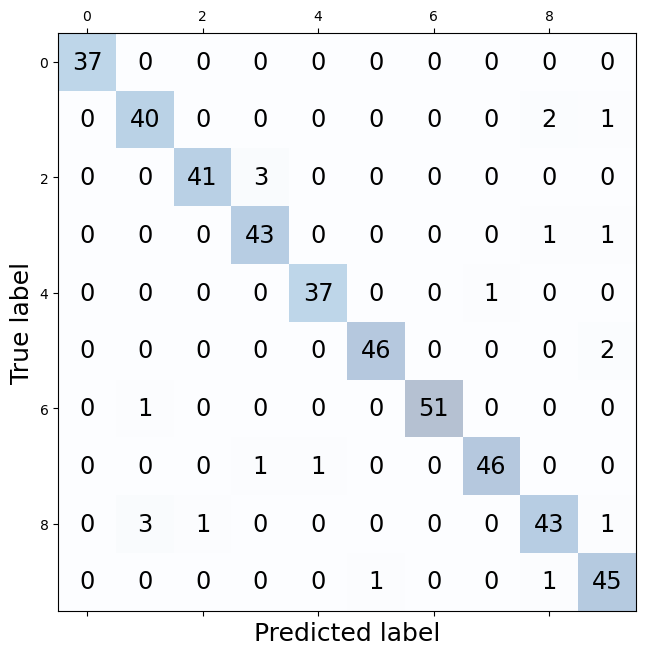

In [106]:
conf_matrix = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)
plt.show()

For the first class, the digit 0, there are 37 samples in the class, and all of these samples
were classified as class 0 (there are no false negatives for class 0). We can see that
because all other entries in the first row of the confusion matrix are 0. We can also see
that no other digits were mistakenly classified as 0, because all other entries in the
first column of the confusion matrix are 0 (there are no false positives for class 0). Some digits were confused with others, though—for example, the digit 2 (third row),
three of which were classified as the digit 3 (fourth column). 


Often it is useful to normalise the confusion matrix so that it is easier to compare numbers. There are different ways to do this, but a standard way is normalise over the 'true' labels or equivalently the rows of the confusion matrix. This lets us see the fraction of the true label were correctly/incorrectly classified.

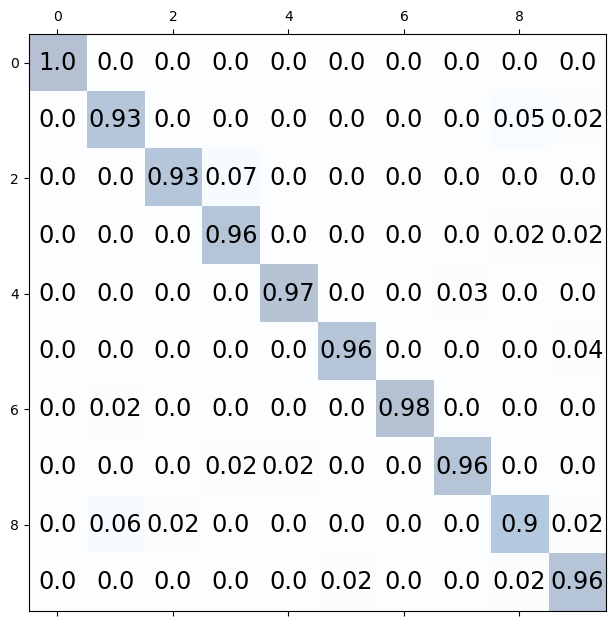

In [108]:
conf_matrix = confusion_matrix(y_test, pred, normalize="true")

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        # We modify this line to print the entries rounded to two decimal places
        ax.text(x=j, y=i,s=np.round(conf_matrix[i, j],2), va='center', ha='center', size='xx-large')
        


With the classification_report function, we can compute the precision, recall,
and f-score for each class:

In [110]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.91      0.96      0.93        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       1.00      0.98      0.99        52
           7       0.98      0.96      0.97        48
           8       0.91      0.90      0.91        48
           9       0.90      0.96      0.93        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Unsurprisingly, precision and recall are a perfect 1 for class 0, as there are no confusions
with this class. We can see that the model has difficulties with class 8.

The most commonly used metric for imbalanced datasets in the multiclass setting is
the multiclass version of the f-score. The idea behind the multiclass f-score is to compute
one binary f-score per class, with that class being the positive class and the other
classes making up the negative classes. Then, these per-class f-scores are averaged
using one of the following strategies:<br>
-  "macro" averaging computes the unweighted per-class f-scores. This gives equal
weight to all classes, no matter what their size is. <br>
-  "weighted" averaging computes the mean of the per-class f-scores, weighted by
their support. This is what is reported in the classification report. <br>
-  "micro" averaging computes the total number of false positives, false negatives,
and true positives over all classes, and then computes precision, recall, and fscore
using these counts.

If you care about each sample equally much, it is recommended to use the "micro"
average f1-score; if you care about each class equally much, it is recommended to use
the "macro" average f1-score:

In [112]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


## Regression Metrics
Evaluation for regression can be done in similar detail as we did for classification—
for example, by analyzing overpredicting the target versus underpredicting the target.
However, in most applications we’ve seen, using the default R2 used in the score
method of all regressors is enough. Other possible metrics include
-  Mean Squared Error
-  Root Mean Squared Error
-  Mean Absolute Error

## Using Evaluation Metrics in Model Selection
We have discussed many evaluation methods in detail, and how to apply them given
the ground truth and a model. However, we often want to use metrics like AUC in
model selection using GridSearchCV or cross_val_score. Luckily scikit-learn
provides a very simple way to achieve this, via the scoring argument that can be used
in both GridSearchCV and cross_val_score. You can simply provide a string
describing the evaluation metric you want to use. Say, for example, we want to evaluate
the SVM classifier on the “nine vs. rest” task on the digits dataset, using the average
precision score. Changing the score from the default (accuracy) to average
precision can be done by providing "average_precision" as the scoring parameter:

In [114]:
# default scoring for classification is accuracy
print("Default scoring:", cross_val_score(SVC(), digits.data, digits.target == 9, cv=5))

# providing scoring="accuracy" doesn't change the results
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9,scoring="accuracy", cv=5)
print("Explicit accuracy:", explicit_accuracy)

ap = cross_val_score(SVC(), digits.data, digits.target == 9, scoring="average_precision", cv=5)
print("Average precision:", ap)

Default scoring: [0.975      0.99166667 1.         0.99442897 0.98050139]
Explicit accuracy: [0.975      0.99166667 1.         0.99442897 0.98050139]
Average precision: [0.97562403 0.9886322  1.         0.99853801 0.95015534]


Using cross_validate, we can even compute several metrics at once:

In [116]:
res = cross_validate(SVC(), digits.data, digits.target == 9, scoring=["accuracy", "average_precision", "recall_macro"], return_train_score=True, cv=5)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_average_precision,train_average_precision,test_recall_macro,train_recall_macro
0,0.021147,0.028752,0.975000,0.994433,0.975624,0.994997,0.887346,0.972222
1,0.009454,0.013560,0.991667,0.995825,0.988632,0.996010,0.958333,0.982252
2,0.009693,0.012976,1.000000,0.995132,1.000000,0.995317,1.000000,0.978780
3,0.009656,0.013739,0.994429,0.995828,0.998538,0.995257,0.972222,0.982252
4,0.009516,0.012768,0.980501,0.996523,0.950155,0.999257,0.902778,0.985725


Similarly, we can change the metric used to pick the best parameters in Grid
SearchCV. Here we look at the average precision score and AUC:

In [118]:
from sklearn.metrics import average_precision_score

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set average precision: {:.3f}".format(average_precision_score(y_test, grid.decision_function(X_test))))#used more often for binary

print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, grid.predict(X_test))))# identical to grid.score here
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test) ) ) # provided by default, just for reference

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.976
Test set average precision: 0.966
Test set accuracy: 0.973
Test set accuracy: 0.973


In [120]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="average_precision")
grid.fit(X_train, y_train)
print("Grid-Search with average precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (average precision): {:.3f}".format(grid.best_score_))
print("Test set average precision: {:.3f}".format(
# identical to grid.score here
average_precision_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, grid.predict(X_test))))

Grid-Search with average precision
Best parameters: {'gamma': 0.01}
Best cross-validation score (average precision): 0.988
Test set average precision: 0.996
Test set accuracy: 0.896


When using accuracy, the parameter gamma=0.0001 is selected, while gamma=0.01 is
selected when using average precision. The cross-validation score is consistent with
the test set score in both cases. As might be expected, the parameters found optimizing
average precision perform better on the test set in terms of average precision,
while the parameters found optimizing accuracy perform better on the test set in
terms of accuracy.

The most important values for the scoring parameter for classification are `accuracy`
(the default), `roc_auc` for the area under the ROC curve, `average_precision` for the
area under the precision-recall curve, `recall_macro` and `precision_macro` for
(macro) averaged precision or recall, `f1`, `f1_macro`, and `f1_weighted` for the binary
f1-score and the different weighted variants. For regression, the most commonly used
values are `r2` for the R2 score, `mean_squared_error` for mean squared error, and `mean_absolute_error` for mean absolute error. You can find a full list of supported
arguments in the documentation or by looking at the SCORER dictionary defined in
the metrics.scorer module:

In [122]:
from sklearn.metrics import get_scorer_names
all_scorers = get_scorer_names()
for x in all_scorers:
    print(x)

accuracy
adjusted_mutual_info_score
adjusted_rand_score
average_precision
balanced_accuracy
completeness_score
explained_variance
f1
f1_macro
f1_micro
f1_samples
f1_weighted
fowlkes_mallows_score
homogeneity_score
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted
matthews_corrcoef
max_error
mutual_info_score
neg_brier_score
neg_log_loss
neg_mean_absolute_error
neg_mean_absolute_percentage_error
neg_mean_gamma_deviance
neg_mean_poisson_deviance
neg_mean_squared_error
neg_mean_squared_log_error
neg_median_absolute_error
neg_negative_likelihood_ratio
neg_root_mean_squared_error
neg_root_mean_squared_log_error
normalized_mutual_info_score
positive_likelihood_ratio
precision
precision_macro
precision_micro
precision_samples
precision_weighted
r2
rand_score
recall
recall_macro
recall_micro
recall_samples
recall_weighted
roc_auc
roc_auc_ovo
roc_auc_ovo_weighted
roc_auc_ovr
roc_auc_ovr_weighted
top_k_accuracy
v_measure_score


## Summary
In this session we discussed cross-validation, grid search, and evaluation metrics, the
cornerstones of evaluating and improving machine learning algorithms. The tools
described in this chapter, together with the algorithms described in previously
are the bread and butter of every machine learning practitioner.

There are two particular points that  warrant repeating,
because they are often overlooked by new practitioners. The first has to do with
cross-validation. Cross-validation or the use of a test set allow us to evaluate a
machine learning model as it will perform in the future. However, if we use the test
set or cross-validation to select a model or select model parameters, we “use up” the
test data, and using the same data to evaluate how well our model will do in the future
will lead to overly optimistic estimates. We therefore need to resort to a split into
training data for model building, validation data for model and parameter selection,
and test data for model evaluation. Instead of a simple split, we can replace each of
these splits with cross-validation. The most commonly used form (as described earlier)
is a training/test split for evaluation, and using cross-validation on the training
set for model and parameter selection.

The second point has to do with the importance of the evaluation metric or scoring
function used for model selection and model evaluation. The full theory of how to make
decisions from the predictions of a machine learning model is beyond the scope of this course. However, it is rarely the case that the end goal of a
machine learning task is building a model with a high accuracy. Make sure that the
metric you choose to evaluate and select a model for is a good stand-in for what the
model will actually be used for. In reality, classification problems rarely have balanced
classes, and often false positives and false negatives have very different consequences.
Make sure you understand what these consequences are, and pick an evaluation metric
accordingly.
